In [103]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np


In [104]:
# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

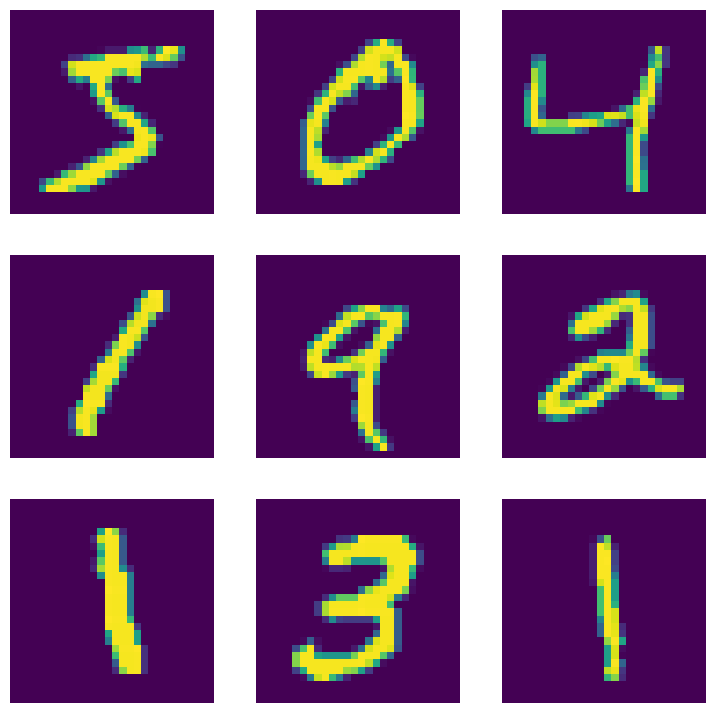

In [106]:
def normalisation(img):
    img = img/255.0
    return img
def examples(x):
    plt.figure(figsize=(9, 9))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = normalisation(x[i])
        plt.imshow(img)
        plt.axis('off')

examples(X_train)

In [107]:
def corrupt(x, noise_amount):
    noise_amount = tf.reshape(noise_amount, [-1, 1, 1, 1])
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0,dtype=tf.float32)
    return x + noise_amount * noise

In [113]:
import tensorflow as tf

class BasicUNet(tf.keras.Model):
    """A minimal UNet-like implementation in TensorFlow/Keras."""

    def __init__(self, in_channels=1, out_channels=1):
        super(BasicUNet, self).__init__()

        # Down layers: Each entry corresponds to one conv layer in the downsampling path
        self.down_layers = [
            tf.keras.layers.Conv2D(32, kernel_size=5, padding='same', input_shape=(None, None, in_channels)),
            tf.keras.layers.Conv2D(64, kernel_size=5, padding='same'),
            tf.keras.layers.Conv2D(64, kernel_size=5, padding='same')
        ]

        # Up layers: Each entry corresponds to one conv layer in the upsampling path
        self.up_layers = [
            tf.keras.layers.Conv2D(64, kernel_size=5, padding='same'),
            tf.keras.layers.Conv2D(32, kernel_size=5, padding='same'),
            tf.keras.layers.Conv2D(out_channels, kernel_size=5, padding='same')
        ]

        self.act = tf.keras.activations.relu

        # Down and Up sampling layers
        self.downscale = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, x, training=False):
        # h will store the intermediate outputs for skip connections
        h = []

        # Downsampling path
        for i, layer in enumerate(self.down_layers):
            x = layer(x)
            x = self.act(x)
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        # Upsampling path
        for i, layer in enumerate(self.up_layers):
            if i > 0:  # Except for the first layer in the upsampling path
                x = self.upscale(x)
                skip = h.pop()  # Retrieve the corresponding skip connection
                x = x + skip
            x = layer(x)
            x = self.act(x)

        return x


In [114]:
input_tensor = tf.random.normal([1, 28, 28, 1]) # batch of one image
model = BasicUNet(in_channels=1, out_channels=1)
output = model(input_tensor)
print(output.shape)  # Check output dimensions


(1, 28, 28, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [117]:
x_train = X_train[..., np.newaxis].astype('float32') / 255.0

batch_size = 128
n_epochs = 5
learning_rate = 1e-3

# Create a tf.data.Dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Define loss and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Lists to store the loss history
losses = []

# Custom training loop
for epoch in range(n_epochs):
    epoch_losses = []

    for step, (x, y) in enumerate(train_dataset):
        # x is the original clean image, y is also the clean image (autoencoder style)
        batch_size_current = tf.shape(x)[0]
        # Generate random noise amounts
        noise_amount = tf.random.uniform(shape=[batch_size_current], minval=0.0, maxval=1.0)
        noisy_x = corrupt(x, noise_amount)

        # Record operations for automatic differentiation
        with tf.GradientTape() as tape:
            pred = model(noisy_x, training=True)
            loss = loss_fn(y, pred)  # Compare with clean x

        # Compute gradients and update weights
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        epoch_losses.append(loss.numpy())
        losses.append(loss.numpy())

    avg_loss = np.mean(epoch_losses)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:.5f}")




Finished epoch 0. Average loss for this epoch: 153.20905
Finished epoch 1. Average loss for this epoch: 0.01768
Finished epoch 2. Average loss for this epoch: 0.01680
Finished epoch 3. Average loss for this epoch: 0.01617
Finished epoch 4. Average loss for this epoch: 0.01584


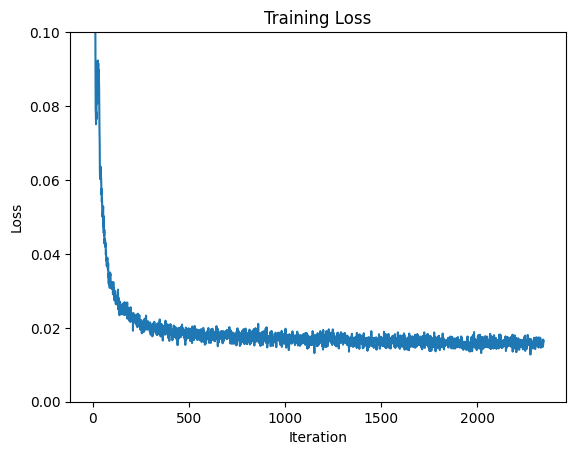

In [118]:
# Plot the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()